In [1]:
import GPy
import numpy as np
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial as spatial
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct,Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from jupyterthemes import jtplot

# Validacion cruzada, pero ahora comparando con OK con datos de entrenamiento de leyes de cobre

In [2]:
# se cargan los datos de entrenamiento
train_data = pd.read_csv('../../GP_Data/cy17_spc_assays_rl6_entry.csv')

# se definen los estilos de los graficos
jtplot.style(theme='onedork',figsize = (16.5,12))

In [3]:
def get_dhids():
    df = pd.read_csv('../../GP_Data/cy17_spc_assays_rl6_entry.csv')
    df_dhid = df['dhid']
    seen = set()
    DHID = []
    for item in df_dhid:
        if item not in seen:
            seen.add(item)
            DHID.append(item)
    return DHID

def get_y_dhid(dhid):
    return train_data.loc[train_data['dhid'] == dhid][['cut']].as_matrix()


def get_test_points_dhid(dhid):
    return train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()


def get_df_test_points(dhid):
    return train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']]


def get_au_xyz_by_dhid(dhid):
    train_data = pd.read_csv('../../GP_Data/cy17_spc_assays_rl6_entry.csv')
    xyz_au = train_data.loc[train_data['dhid'] == dhid][['midx','midy','midz','cut']].as_matrix()
    return xyz_au


def get_traningSet(dhid,distancia):
    # retorna X dataFrame con los puntos de
    # entrenamiento para todo el sondaje dhid
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train_dhid = train_data_dhid[['dhid','midx','midy','midz']]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['dhid','cut']]
    
    test_points = get_test_points_dhid(dhid)
    test_tree = spatial.cKDTree(test_points)
    train_tree = spatial.cKDTree(X_train)
    
    idx_rep = test_tree.query_ball_tree(train_tree,distancia)
    idx_sin_rep = list(set([indice for lista in idx_rep for indice in lista]))
    
    return X_train_dhid.iloc[idx_sin_rep,:], y.iloc[idx_sin_rep,:]

<span style="color:red">Conseguir datos de pozos con valores de ugcut </span>

In [33]:
# genero el .csv para entrenar con el kriging
# sondaje
dhid = 'SPD1647'
# datos de entrenamiento para kriging
X_df, y_df = get_traningSet(dhid,50)
X_df = X_df.assign(cut = y_df['cut'])
X_df.columns.values
X_df.to_csv('../../GP_Data/data_kriging.csv', index=False)

# datos donde testear para kriging
X_test_ok = get_df_test_points(dhid)
X_test_ok.to_csv('../../GP_Data/test_kriging.csv', index=False)

X_df

,dhid,midx,midy,midz,cut
37097,SPD1738,474099.775,7479492.952,1295.432,0.220
37098,SPD1738,474099.477,7479492.818,1289.441,0.240
37099,SPD1738,474099.179,7479492.684,1283.450,0.216
37100,SPD1738,474098.873,7479492.551,1277.460,0.296
37101,SPD1738,474098.567,7479492.412,1271.469,0.262
37102,SPD1738,474098.269,7479492.279,1265.478,0.329
37103,SPD1738,474097.974,7479492.149,1259.487,0.395
37104,SPD1738,474097.678,7479492.015,1253.495,0.416
37105,SPD1738,474097.336,7479491.872,1247.507,0.313
37106,SPD1738,474096.950,7479491.718,1241.521,0.329


In [37]:
train_data.loc[train_data['cut'] < 0 ]

,compid,dhid,midx,midy,midz,topx,topy,topz,botx,boty,...,alte16,lito_f,lito17,mine_f,mine18,dom_f,dom_19,gs_py,gs_p20,ore


In [106]:
def cross_validation(modelo,ker,Plotear = True):
    # En vez de estimar puntualmente, se estima
    # cada dhid con un solo conjunto de entrenamiento
    
    # se define el objeto dataFrame que almacenara las predicciones
    cols_names = ['dhid', 'midx', 'midy', 'midz', 'au_gp', 'sigma']
    df = pd.DataFrame(columns=cols_names)
    
    # diccionario que guardara las predicciones por dhid
    dicc_preds = dict() 
    
    # distancia a la que se buscan muestras (quizas es mejor tomar la minima necesaria?)
    distancia = 100
    DHIDs = get_dhids()
    #for dhid in DHIDs:
    for dhid in ['SPD1647']:
    
        # se define la lista con key dhid para guardar predicciones
        dicc_preds[dhid] = list()
        
        # se obtienen los datos de entrenamiento
        X_df,y_df = get_traningSet(dhid,distancia)
        X = X_df[['midx','midy','midz']].as_matrix()
        y = y_df[['cut']].as_matrix()
        
        # se obtienen puntos donde se realiza la estimacion
        X_test = get_test_points_dhid(dhid)
        
        # se inicializa el objeto moodelo segun str modelo
        if modelo == 'sgpr':
            m = GPy.models.SparseGPRegression(X,y,ker)
            #m.inducing_inputs.constrain_fixed()
        else:
            m = GPy.models.GPRegression(X,y, ker)
        # se intenta realizar el modelo
        y_preds = np.zeros((X_test.shape[0],1))
        try:
            m.optimize(messages = True, max_f_eval = 1000)
            y_preds,_ = m.predict(X_test)
            print('se logro optimizar la funcion')
        except np.linalg.LinAlgError:
            print('La matriz definida por el kernel no es definida positiva')
            pass
        print('Entrenamiento para sondaje {} terminado'.format(dhid))
        # transformar restricciones en ndarray, por sia caso
        y_preds_ndarray = np.array(y_preds.copy())
        dicc_preds[dhid] = y_preds_ndarray
        
        # guardar valores reales de oro en los puntos test de dhid
        y_medido = get_y_dhid(dhid).reshape(y_preds_ndarray.shape)
        
        # se analizan los resultados por dhid
        fig, ax = plt.subplots()
        ax.scatter(y_medido,y_preds_ndarray , edgecolors=(0, 0, 0))
        ax.plot([y_medido.min(), y_medido.max()], [y_medido.min(), y_medido.max()], 'k--', lw=2)
        ax.set_xlabel('Medido')
        ax.set_ylabel('Prediccion')
        ax.set_title('Regresion para el sondaje %s' % dhid)
        # ax.set_title('DHID:%s, Kernel: %s' % (dhid,gp.kernel_))
        print('')
        print('#############################################################')
        print('')
        
    if Plotear:
        plt.show()
    return m,dicc_preds

In [75]:
def get_data_dhid_test_point(dhid, test_point, distancia, train_data):
    # Esta funcion retorna una tupla X,y
    # de modo que X no contiene puntos del
    # sondaje de id dhid, y adem'as retorna
    # solo los X dentro de una esfera de radio
    # distancia entorno a test_point

    # X_dhid = train_data.loc[train_data['dhid']==dhid][['midx','midy','midz']].as_matrix()
    dhid_bool = train_data['dhid'] != dhid
    train_data_dhid = train_data[dhid_bool]
    X_train = train_data_dhid[['midx','midy','midz']].as_matrix()
    y = train_data_dhid[['cut']].as_matrix()
    #X_train = train_data.loc[train_data['dhid'] != dhid][['midx', 'midy', 'midz']].as_matrix()
    #y = train_data.loc[train_data['dhid'] != dhid]['au'].as_matrix()
    
    # tree_X_dhid = spatial.cKDTree(X_dhid)
    tree_test = spatial.cKDTree(X_train)
    # pairsList = tree_X_dhid.query_ball_tree(tree_test,distancia)
    idx = tree_test.query_ball_point(list(test_point), distancia)  # como se hace para
    # un punto no se repiten
    # idx = list(set(x for l in pairsList for x in l)) # indices de los puntos test
    # que se encuentran a <= distancia
    
    trainable =False
    if len(idx) >= 20:
        trainable == True
    return X_train[idx, :], y[idx], trainable


def estimacion_by_point(modelo,ker,Plotear = False):
    # se cargan los sondajes y se obtienen los dhid
    train_data = pd.read_csv('../../GP_Data/cy17_spc_assays_rl6_entry.csv')
    DHIDs = get_dhids()

    # se define la distancia a la cual se buscan los sondajes para entrenar
    distancia = 100

    train_dicc = dict()
    dicc_preds = dict() # se gurdan las estimaciones hechas por id
    for dhid in ['SPD1647']:
        print('Se ajusta el modelo para id: {}\n'.format(dhid))

        y_preds = list()
        y_medido = list()

        X_dhid = train_data.loc[train_data['dhid'] == dhid][['midx', 'midy', 'midz']].as_matrix()
        y_medido_matrix = train_data.loc[train_data['dhid'] == dhid][['cut']].as_matrix()
        y_medido.extend(list(y_medido_matrix))
        print('Puntos a estimar:{}'.format(X_dhid.shape[0]))
        print('\n')
        for test_point in X_dhid:
            # se obtienen los datos de entrenamiento
            X, y, trainable = get_data_dhid_test_point(dhid, test_point, distancia, train_data)
            
            X_std = (X - X.mean()) / X.std()
            y_std = (y - y.mean()) / y.std()
            
            # inicializacion  del modelo
            
            #m = GPy.models.GPRegression(X,y,kernel=ker,) # lo utilizo para usar el kernel con periodo
            if modelo == 'sgpr':
                m = GPy.models.SparseGPRegression(X_std, y_std, ker) #pol, per not implemented
            elif modelo == 'gpr':
                m = GPy.models.GPRegression(X_std,y_std,kernel=ker)
            
            try:
                #print('Datos de entrenamiento: {}'.format(X.shape[0]))
                m.optimize(messages=False,max_f_eval = 1000)
                test_point_std = (test_point - X.mean()) / X.std()
                y_pred, sigma = m.predict(np.array([[test_point[0],
                                                     test_point[1],test_point[2]]]))
                y_preds.extend(list(y_pred*y.std()+y.mean()))
                #y_preds.extend(list(y_pred*y.std()+y.mean()))
            except np.linalg.LinAlgError:
                print('La matriz definida por el kernel no es definida positiva')
                y_pred = 0
                sigma = 0
                y_preds.extend(list([0]))
                pass
            except GPy.util.linalg.LinAlgError:
                print('La matriz no es definida positiva, incluso con jitter')
                pass
            fila = []
            fila.extend([dhid])
            fila.extend(list(test_point))
            fila.extend([y_pred, sigma])

            df = df.append(pd.DataFrame([fila], columns=cols_names))

        print('Entrenamiento para sondaje {} terminado'.format(dhid))
        y_preds = np.array(y_preds)
        dicc_preds[dhid] = y_preds # guardamos las estimaciones por dhid
        y_medido = np.array(y_medido)
        
        # se analizan los resultados por dhid
        fig, ax = plt.subplots()
        ax.scatter(y_medido, y_preds, edgecolors=(0, 0, 0))
        ax.plot([y_medido.min(), y_medido.max()], [y_medido.min(), y_medido.max()], 'k--', lw=2)
        ax.set_xlabel('Medido')
        ax.set_ylabel('Prediccion')
        ax.set_title('Regresion para el sondaje %s' % dhid)
       # ax.set_title('DHID:%s, Kernel: %s' % (dhid,gp.kernel_))
        print('')
        print('#############################################################')
        print('')
    
    if Plotear:
        plt.show()
    
    # se guardan las predicciones en path_csv+nombre
    df.to_csv(path_csv + nombre + '.csv', sep=',')
    return train_dicc, dicc_preds

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82




 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Entrenamiento para sondaje SPD1647 terminado

#############################################################



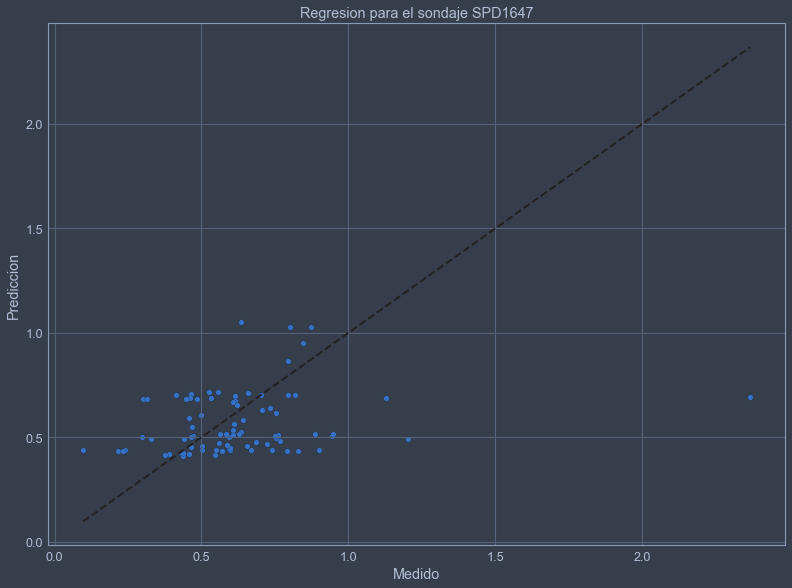


Parametros del kernel despues del entrenamiento

  Mat32.       |              value  |  constraints  |  priors
  variance     |  4.54991153413e-09  |      +ve      |        
  lengthscale  |     0.999987710648  |      +ve      |        


In [83]:
# kernel: Matern32(z)
ker = GPy.kern.Matern32(input_dim=1, active_dims=[2])
print(ker)
print('')
_,_, dicc_preds_mat32Z = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

In [ ]:
# kernel: Matern32(x,y)+ Matern32(z)
ker = GPy.kern.Matern32(input_dim=1, active_dims=[2]) +GPy.kern.Matern32(input_dim=2, active_dims=[0,1])
print(ker)
print('')
_,_, dicc_preds_mat32XY_Z = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (3,)  |      +ve      |        

Se ajusta el modelo para id: SPD1647

Puntos a estimar:82


Entrenamiento para sondaje SPD1647 terminado

#############################################################



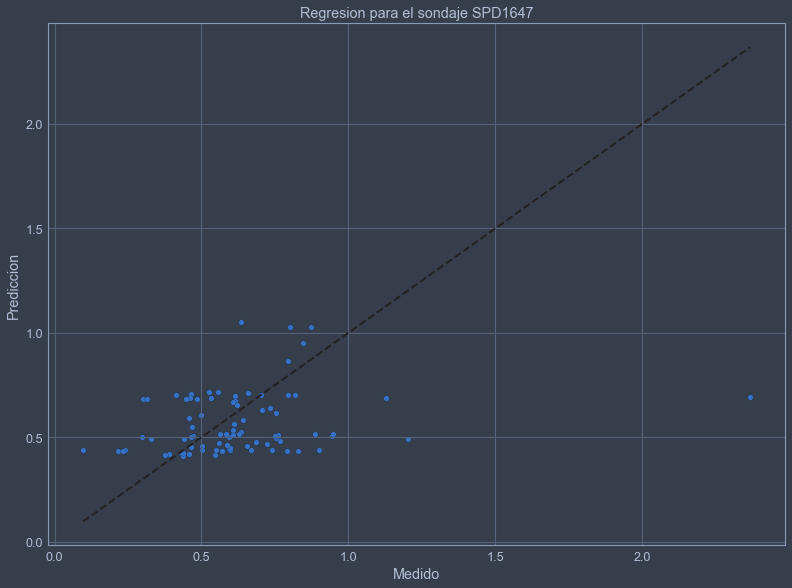


Parametros del kernel despues del entrenamiento

  Mat32.       |              value  |  constraints  |  priors
  variance     |  3.54628697273e-09  |      +ve      |        
  lengthscale  |               (3,)  |      +ve      |        
LengthScales de Mat52Ard


AttributeError: 'Matern32' object has no attribute 'Mat32'

In [82]:
# kernel Matern32ARD
mat32_ard = GPy.kern.Matern32(3,ARD=True)



ker = mat32_ard# este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
y_preds, y_medido, dicc_preds_mat32ARD = main_jupyter('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)
print('LengthScales de Mat52Ard')
print(ker.Mat32.lengthscale)

  Cosine.      |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   2.477381e+02   2.278057e+02 
    00s09  0016   2.469296e+02   1.555279e+02 
    00s17  0030   2.437690e+02   1.838296e-01 
    00s17  0032   2.437655e+02   4.592118e-03 

 C:\Users\jpdon\Anaconda3\lib\site-packages\GPy\core\gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 3. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


    00s18  0034   2.437648e+02   5.427414e-04 
    00s18  0035   2.437645e+02   1.480348e-04 
    00s23  0045   2.437643e+02   1.636209e-06 
Runtime:     00s23
Optimization status: Converged

se logro optimizar la funcion
Entrenamiento para sondaje SPD1647 terminado

#############################################################



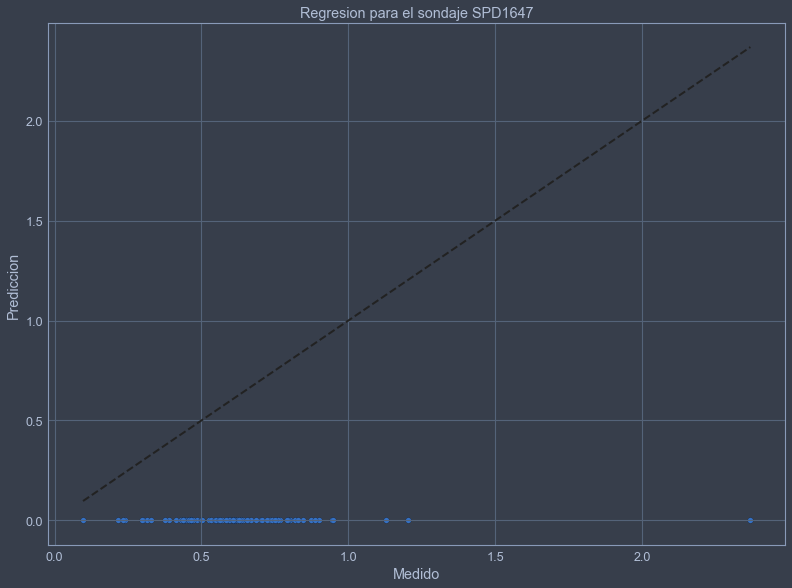


Parametros del kernel despues del entrenamiento

  Cosine.      |              value  |  constraints  |  priors
  variance     |  1.53954574092e-08  |      +ve      |        
  lengthscale  |     0.799886836373  |      +ve      |        


In [115]:
# kernel: Cosine
cos = GPy.kern.Cosine(input_dim=1, active_dims=[2])#+ GPy.kern.RBF(input_dim=2, active_dims=[0,1])
ker = cos# este kernel, con los parametros libre mejor un poquito el modelo
print(ker)
print('')
m_cos, dicc_preds_cosZ= cross_validation('sgpr',ker,Plotear = True)
print('')
print('Parametros del kernel despues del entrenamiento\n')
print(ker)


In [81]:
# funciones para visualizar los resultados
def plot_deriva_dhid(eje,dhid):
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    xyz_au = get_au_xyz_by_dhid(dhid)
    n = xyz_au.shape[0]
    xx = xyz_au[:,eje]
    au = xyz_au[:,3]
    xmin = np.amin(xx)
    xmax = np.amax(xx)
    ymin = np.amin(au)
    ymax = np.amax(au)
    plt.scatter(xx,au,marker = '.',s = 200,label = 'Sondaje: '+dhid)
    #plt.plot(xx,au,linestyle = '-.',linewidth = 2,label = 'Sondaje: '+dhid)
    #plt.plot(xx,au,'bx',label = 'Sondaje: '+dhid)
    plt.title('Deriva por el eje %s para sondaje %s. (Puntos a estimar: %s)' % (eje_str,dhid,n))
    plt.xlabel('mid'+eje_str)
    plt.ylabel('au')
    plt.legend()
    plt.ylim((0,ymax))
    plt.xlim((xmin,xmax))
    plt.grid(True)


def plot_estimacion(dicc,dhid,eje,etiqueta):
    eje_str = 'z'*(eje-1)*(int((eje)/2))+'x'*(1-eje)*int((2-eje)/2)+'y'*(2-eje)*(eje)
    xyz_au = get_au_xyz_by_dhid(dhid)
    xx = xyz_au[:,eje]
    au = dicc[dhid]
    au_dhid = xyz_au[:,3]
    #plt.scatter(xx,au,marker = 'x',s = 50,label = 'Kernel: '+etiqueta)
    plt.plot(xx,au, marker = '+',label = 'Kernel: '+etiqueta)
    plt.legend()
    xmin = np.amin(xx)
    xmax = np.amax(xx)
    ymin = np.amin(au_dhid)
    ymax = np.amax(au_dhid)
    plt.ylim((0,ymax))
    plt.xlim((xmin,xmax))
    plt.grid(True)


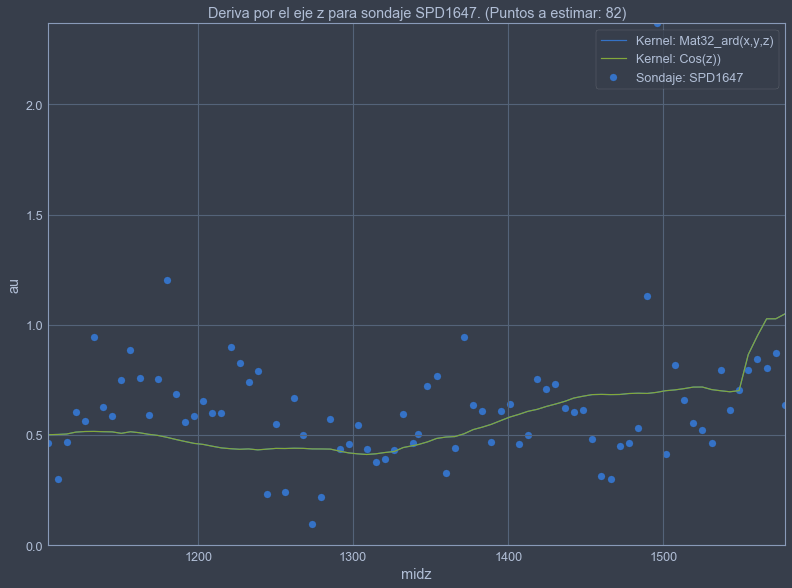

In [96]:
eje = 2
plt.figure()
plot_deriva_dhid(eje,dhid)
plot_estimacion(dicc_preds_mat32ARD,dhid, eje,'Mat32_ard(x,y,z)')
plot_estimacion(dicc_preds_cosZ,dhid, eje,'Cos(z))')

plt.show()